In [1]:
import time
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter

# natural language toolkit
import nltk
from nltk.corpus import stopwords
from string import punctuation

# import sklearn models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regresion model
from sklearn.linear_model import LogisticRegression
# Naive Bayes model
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

## Extract and laod Dataset

In [2]:
# extract and load dataset
DATASET_ZIP = 'Datasets/Tweets/tweets_data.zip'
DATASET_TARGET = 'tweets'

# helper extraction
def extract_dataset(source_dir=DATASET_ZIP, target_dir=DATASET_TARGET):
    # takes zip folder and unzips to target destination
    try:
        with zipfile.ZipFile(DATASET_ZIP,'r') as zip_ref:
            zip_ref.extractall(DATASET_TARGET)
    except IOError:
        print('rror: File does not appear to exist.')

# helper load function
def load_dataset(source_dir, dataset_name, sep=','):
    # loads csv data into pandas DataFrame
    csv_path = os.path.join(source_dir, dataset_name)
    tweets = pd.read_csv(csv_path,
                         # for some reason the dataset has more than 2 unused columns
                         # so we only get the first 2, class and text
                         usecols=['Sentiment', 'SentimentText'],
                         error_bad_lines=False,
                         encoding='ISO-8859-1',
                        )
    return tweets

# extract zip file
extract_dataset(DATASET_ZIP, DATASET_TARGET)
# and load data
tweets = load_dataset(source_dir='tweets', dataset_name='tweets_sentiment.csv')

print(f'data frame size:{tweets.shape}')

data frame size:(1048575, 2)


In [3]:
# print some positive samples
tweets[tweets['Sentiment']==0].head(15)

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
5,0,or i just worry too much?
7,0,Sunny Again Work Tomorrow :-| ...
10,0,I must think about positive..
12,0,this weekend has sucked so far
13,0,jb isnt showing in australia any more!
14,0,ok thats it you win.


In [4]:
# print some negative samples
tweets[tweets['Sentiment']==1].head(15)

,Sentiment,SentimentText
2,1,omg its already 7:30 :O
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
8,1,handed in my uniform today . i miss you ...
9,1,hmmmm.... i wonder how she my number @-)
11,1,thanks to all the haters up in my face a...
17,1,Feeling strangely fine. Now I'm gonna go l...
22,1,You're the only one who can see this cause...
28,1,"goodbye exams, HELLO ALCOHOL TONIGHT"
38,1,uploading pictures on friendster
41,1,(: !!!!!! - so i wrote something last week. ...


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
Sentiment        1048575 non-null int64
SentimentText    1048575 non-null object
dtypes: int64(1), object(1)
memory usage: 16.0+ MB


### Time to get some understanding of the data

Before we do anything we could do some basic text clean up, like triming spaces and converting everything to lower case, etc.

In [6]:
# here a copy is created in order to do some data exploration
data_exploration = tweets.copy()

In [22]:
def text_cleanup(dataframe, text_column='SentimentText'):
    """
    This function is meant to do some text cleaning:
    Removes leading white spaces, HTML links, converts to lowercase.
    """
    
    # trim/strip left and right whitespaces
    dataframe[text_column] = dataframe[text_column].str.strip()
    # text to lowercase
    dataframe[text_column] = dataframe[text_column].str.lower()
    # removes hyperlinks - I will assume that they don't add much value
    dataframe[text_column] = [re.sub(r'https?:\/\/.*\/\w*', '', w) for w in dataframe[text_column]]
    # removes HTML special sintax such as &amp;
    dataframe[text_column] = [re.sub(r'\&\w*;', '', w) for w in dataframe[text_column]]
    
    return dataframe

def remove_stopwords(sentence):
    """ 
    Gets rid of some english stopwords as there could be some stop words that might be bias towards sadness like not, nor, but, etc.
    """
    # stopwords to ignore based on personal bias (this is a subset of the NLTK full list of english words)
    forbidden_words = ['it', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'a', 'an', 'the', 'and', 'of', 'at', 'by', 'for',
                       'before', 'after', 'above', 'below', 'to', 'from', 'then', 'here', 'when', 'so', 'than', 'too', 'very', 's', 't', 'just', 'now','d', 
                       'll', 'm', 'o', 're', 've', 'y', 'i','you','my','in', 'on', 'have']
    
    sentence = ' '.join([w for w in sentence.split(' ') if w not in forbidden_words])
    
    return sentence

def tokenize_sentence(dataframe, text_column='SentimentText'):
    """
    Converts sentence into list of words.
    """
    dataframe[text_column] = [w.split() for w in dataframe['SentimentText']]
    
    return dataframe
    

In [23]:
# apply above data transformations:
data_exploration = text_cleanup(data_exploration, text_column='SentimentText')
data_exploration['SentimentText'] = data_exploration['SentimentText'].apply(remove_stopwords)

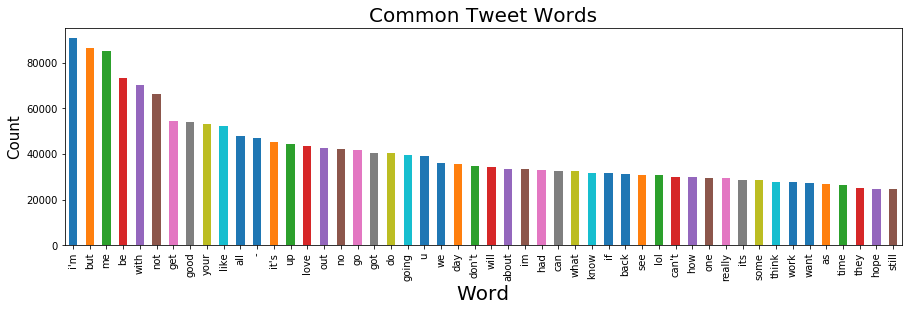

In [24]:
# get top most used words in tweets
top_n = 50
top_words = pd.Series(' '.join(data_exploration['SentimentText']).split()).value_counts()[:top_n]

# ploting top words
plt.figure(figsize=(15, 4))
top_words.plot.bar()
plt.title('Common Tweet Words', fontsize=20)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Count', fontsize=15)

plt.show()

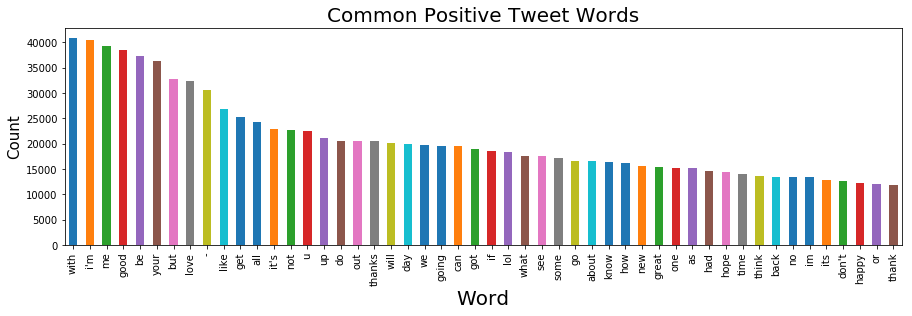

In [25]:
# get top most negative words in tweets
negative_tweets = data_exploration['SentimentText'][data_exploration['Sentiment']==1]
top_words = pd.Series(' '.join(negative_tweets).split()).value_counts()[:top_n]
                      
# ploting top words
plt.figure(figsize=(15, 4))
top_words.plot.bar()
plt.title('Common Positive Tweet Words', fontsize=20)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Count', fontsize=15)

plt.show()

As we can see the hypothesis that some stop words are bias towards negative meaning is true, for example the stopword "But" is one of the most used in negative tweets, similar case with the word "no" and "not" keeping this words may help the models shift its probabilities.

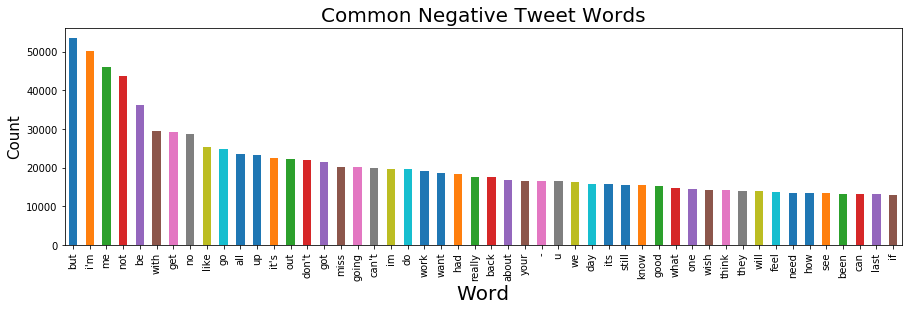

In [26]:
# get top most negative words in tweets
positive_tweets = data_exploration['SentimentText'][data_exploration['Sentiment']==0]
top_words = pd.Series(' '.join(positive_tweets).split()).value_counts()[:top_n]

# ploting top words
plt.figure(figsize=(15, 4))
top_words.plot.bar()
plt.title('Common Negative Tweet Words', fontsize=20)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Count', fontsize=15)

plt.show()

In [ ]:
# display n most common words in thw tweets

top_n = 30
top_words = pd.Series(' '.join(data_exploration['SentimentText'])).value_counts()[:top_n]

top_words = pd.Series(' '.join(df_train['name']).lower().split()).value_counts()[:top_n]

plt.figure(figsize=(15, 10))
top_words.plot.bar()
plt.title('Common "name" words', fontsize=20)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Count', fontsize=15)

plt.show()

In [ ]:
#print(stopwords.words('english'))

In [ ]:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",
 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
 "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
data_exploration.head()

In [ ]:
# this is feature engineering... to try to get a relationship between length of the tweet and sentiment
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
tweets['word count'] = tweets['text'].apply(word_count)
tweets.head(3)

In [ ]:
# plot word count distribution for both positive and negative sentiments
x = tweets['word count'][tweets.Sentiment == 1]
y = tweets['word count'][tweets.Sentiment == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [ ]:
# tokenize helper function
def text_process(text):
    
    # Check characters to see if they are punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # removes stopwords 
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return clean_words


In [ ]:
# clean tweets
def cleanse_tweet(tweet):
    # Removes HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond BMP of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    
    return tweet

In [ ]:
# clense tweet, remove special characters using regex
tweets['text'] = tweets['text'].apply(cleanse_tweet)


In [ ]:
tweets.head()

In [ ]:
# train:test split, 80:20 
msg_train, msg_test, class_train, class_test = train_test_split(tweets['text'],
                                                                tweets['Sentiment'],
                                                                test_size=0.2)

msg_train.head(10)

# Naive Bayes

In [ ]:
# Naive Bayes Test

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)), # converts strings to integer counts
    ('tfidf',TfidfTransformer()), # converts integer counts to weighted TF-IDF scores
    ('classifier',BernoulliNB()) # train on TF-IDF vectors with Naive Bayes classifier
])


In [ ]:
pipeline.fit(msg_train,class_train)

In [ ]:
predictions = pipeline.predict(msg_test)

In [ ]:
print(classification_report(class_test,predictions))

In [ ]:
# Naive Bayes accuracy
print('Naive Bayes:\n\t Accuracy ~ {0:.2f}%'.format(np.mean(predictions == class_test)*100))

In [ ]:
sns.heatmap(confusion_matrix(class_test,predictions),annot=True, fmt='g')


# Logistic Regresion

In [ ]:
# set up logistic regresion pipeline
text_clf_LogisticRegression = Pipeline([('vect', CountVectorizer(analyzer=text_process, ngram_range=(2,4), stop_words='english',lowercase=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),])



In [ ]:
# train the model
text_clf_LogisticRegression.fit(msg_train,class_train)

In [ ]:
# get predictions
predicted_LogisticRegression = text_clf_LogisticRegression.predict(msg_test)

In [ ]:
print(classification_report(class_test,predicted_LogisticRegression))

In [ ]:
# Logistic Regression
print('Logistic Regression:\n\t Accuracy ~ {0:.2f}%'.format(np.mean(predicted_LogisticRegression == class_test)*100))

In [ ]:
sns.heatmap(confusion_matrix(class_test,predicted_LogisticRegression),annot=True, fmt='g')